In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, create_gif, clear_temp
from modules.problems import LorenzSystem
from modules.training import train

import scienceplots
plt.style.use(['science', 'grid'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
import torch.nn as nn

class SinActivation(nn.Module):
    def __init__(self, alpha=1, learnable=False):
        super(SinActivation, self).__init__()
        if learnable:
            self.alpha = nn.Parameter(torch.as_tensor(alpha))
        else:
            self.alpha = alpha
    def forward(self, x):
        return torch.sin(x)
    
class Swish(nn.Module):
    def __init__(self, beta=1, learnable=False):
        super(Swish, self).__init__()
        if learnable:
            self.beta = nn.Parameter(torch.as_tensor(beta))
        else:
            self.beta = beta
    def forward(self, x):
        return x * nn.functional.sigmoid(self.beta * x)

In [26]:
clear_temp()

In [27]:
def f(problem, N_F, loss_history=None):
    zero = torch.tensor([0.], requires_grad=True).to(device)
    
    timestep = problem.T / 5
    k = (len(loss_history) // 5000 + 1)
    t = torch.linspace(0, timestep * k, N_F * k, requires_grad=True).reshape(-1, 1)
    # t = torch.linspace(0, problem.T, N_F, requires_grad=True).reshape(-1, 1)
    return zero, t

problem_number = 3
problem = LorenzSystem.get_problem(problem_number)
name = f'lz{problem_number}'

L, W = 2, 64
model = FeedForwardNetwork(L, W, output_dim=3, activation=nn.Tanh())
# model = FeedForwardNetwork(L, W, output_dim=3, activation=SinActivation(alpha=1))

num_iters = 25000
plot_every = 250

coef = 0.3

train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {'lr': 1e-2},
        'scheduler': {
            'rule': torch.optim.lr_scheduler.StepLR, 
            'parameters': {'step_size': 20000}
            },
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 2500,
            'N_points': {'N_F': 1024*2},
            'generation_function': f
        },
        'coefs': [[coef], [1 - coef, 1 - coef, 1 - coef]],
        'dynamic_coefs': -1,
        'coef_func': None
    },
    logging_params={
        'loss':  1000,
        'norms': 1000,
        'error': 1000,
        'steps': 1000,
        'log_dir': None
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 3)
    },
    name=name,
    print_every=2500
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/lz/{name}_test.gif'
)

Iter     0 	 240.58991308700035
Iter  2500 	 148.37757582479114
Iter  5000 	 139.51724125244002
Iter  7500 	 137.32133754581182
Iter 10000 	 147.3556368613987
Iter 12500 	 145.67812964294873
Iter 15000 	 143.1304901465417
Iter 17500 	 145.4028931397215
Iter 20000 	 142.8847780746551
Iter 22500 	 142.30606062254225
Final error: 142.63657058468155
Creating gif...


In [30]:
import json
files = ['./logging/diff1.json', './logging/diff1_sin.json', './logging/diff1_swish.json']

fig, ax = plt.subplots(1, 2, width_ratios=[1, 1])

iters = np.arange(0, num_iters, 1000)
for i, activ in enumerate(['tanh', 'sin', 'swish']):
    with open(f'./logging/{files[i]}.json', 'r') as file:
        log = json.load(file)

    loss_history = []
    error_history = []
    step_history = []
    for i in range(0, num_iters, 1000):
        loss_history.append( log[str(i)]['loss'])
        error_history.append(log[str(i)]['error'])
        step_history.append( log[str(i)]['step'])
        
    loss_history =  np.array(loss_history )
    error_history = np.array(error_history)
    step_history =  np.array(step_history )
    
    ax[0].plot(iters, loss_history[:, 2], label=activ)
    
    ax[1].plot(iters, step_history, label=activ)
    ax[1].plot(iters, error_history, label=activ, linestyle='dashed')

ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_yscale('log')

plt.show()

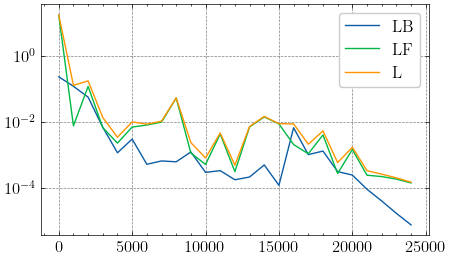

In [31]:

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(iters, loss_history[:, 0], label='LB')
plt.plot(iters, loss_history[:, 1], label='LF')
plt.plot(iters, loss_history[:, 2], label='L')

ax.set_yscale('log')

plt.legend()
plt.show()

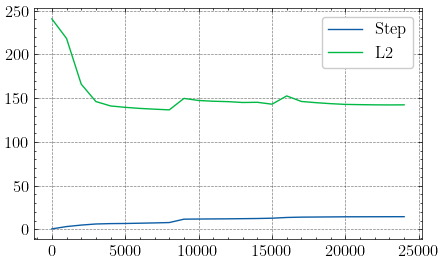

In [37]:
iters = np.arange(0, num_iters, 1000)
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
plt.plot(iters, step_history, label='Step')
plt.plot(iters, error_history, label='L2')

# ax.set_yscale('log')

plt.legend()
plt.show()